# `photoeccentric` Tutorial

In this tutorial, I will create a simulated transit based on a Kepler planet and demonstrate how to use `photoeccentric` to recover the planet's eccentricity using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using to implement the photoeccentric effect is compiled into a package called `photoeccentric`, and can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

I'll define the conversions between solar mass -> kg and solar radius -> meters for convenience.

In [2]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

I'm using the sample of "cool KOIs" from [Muirhead et al. 2013](https://iopscience.iop.org/article/10.1088/0067-0049/213/1/5), and their properites from spectroscopy published here.

In [3]:
muirhead_data = pd.read_csv("/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")


I'm reading in a file containing data for all Kepler planets from the Exoplanet Archive (`planets`), then only taking these data for planets in the Muirhead et al. 2013 sample (`spectplanets`).

In [4]:
# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

Now, I'm reading in the entire Kepler/Gaia dataset from [gaia-kepler.fun]. I'm again matching these data with the objects in our sample (`muirhead_gaia`). I'm using the DR2 data with a 4 arcsecond search radius.

Then I'll combine the spectroscopy data with Kepler/Gaia data for our sample.

In [5]:
# Kepler-Gaia Data
kpgaia = Table.read('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


# Defining a "test planet"

I'm going to pick a random planet from our sample to test how well `photoeccentric` works. Here, I'm picking Kepler-1582 b, a super-Earth orbiting an M dwarf [Exoplanet Catalog Entry](https://exoplanets.nasa.gov/exoplanet-catalog/2457/kepler-1582-b/). It has an orbital period of about 5 days.

First, I'll use the spectroscopy data from Muirhead et al. 2013 and Gaia luminosities to constrain the mass and radius of the host star beyond the constraint published in the Exoplanet Archive. I'll do this by matching these data with stellar isochrones [MESA](https://iopscience.iop.org/article/10.3847/0004-637X/823/2/102) (check this ciation) and using the masses/radii from the matching isochrones to constrian the stellar density.

In [6]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]


In [7]:
# Read in MESA isochrones
isochrones = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')


KeyboardInterrupt: 

##### Using `ph.fit_isochrone_lum()` to match isochrones to stellar data

In [8]:
iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

NameError: name 'isochrones' is not defined

In [9]:
# Write to csv, then read back in (prevents python notebook from lagging)
iso_lums.to_csv("feb9_21_iso_lums_" + str(kepid) + ".csv")

NameError: name 'iso_lums' is not defined

In [10]:
isodf = pd.read_csv(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/feb9_21_iso_lums_' + str(kepid) + '.csv')

I'm determining the mass and radius constraints of this star based on the isochrones that were consistent with the observational data.

In [11]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

##### Using `ph.find_density_dist_symmetric()` to create a stellar density distribution from symmetric (Gaussian) distributions based on mstar and rstar (from isochrones). 
Note: this does not necessarily mean the resulting density distribution will appear symmetric.

In [12]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err)

# Creating a fake light curve based on a real planet

I'm pulling the planet parameters of Kepler-1582 b from the exoplanet archive using `ph.planet_params_from_archive()`. This will give me the published period, Rp/Rs, and inclination constraints of this planet. (It will also return some other parameters, but we don't need those right now).

#### I'm calculating a/Rs using `ph.calc_a()`, instead of using the a/Rs constraint from the Exoplanet Archive. The reason is because a/Rs must be consistent with the density calculated above from spectroscopy/Gaia for the photoeccentric effect to work correctly, and the published a/Rs is often inconsistent. a/Rs depends on the orbital period, Mstar, and Rstar.

In [13]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


Now, I'll create a fake transit using `batman`.
I'm creating a model with the period, Rp/Rs, a/Rs, and inclination specified by the Kepler catalog entry and the density constraints I determined

I'll create the transit model with an $e$ and $w$ of my choice. This will allow me to test whether `photoeccentric` accurately recovers the $(e,w)$ combination I have input. I'll start with $e = 0.0$ and $w = 90.0$ degrees.

## $e = 0.0$, $\omega = 90.0$

In [14]:
time = np.linspace(-24, 24, 10000)

In [15]:
def planetlc(time, per, rp, a, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0
    params.w = w                          #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [16]:
# Calculate flux from transit model
w = 90.0
flux = planetlc(time, period, rprs, a_rs, i, w)

# Adding some gaussian noise
noise = np.random.normal(0,0.00005,len(time))
nflux = flux+noise
flux_err = np.array([0.00005]*len(nflux))

Text(0, 0.5, 'Flux')

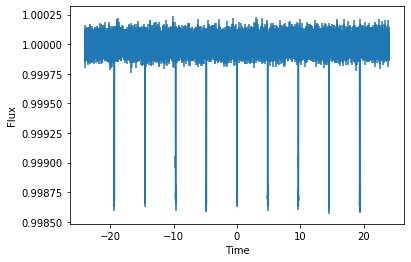

In [17]:
plt.errorbar(time, nflux, yerr=flux_err)
plt.xlabel('Time')
plt.ylabel('Flux')
#plt.xlim(-1, 1)

## Fitting the transit

I'm using the Astropy BLS method to determine the period of the fake light curve, and use this as the period "guess" (`per_guess`).

In [18]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")
per_guess = np.asarray(periodogram.period)[int(np.median(np.argmax(periodogram.power)))]

Now, I'm fitting the transit shape with scipy.curve_fit. $p$, $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e != 0, the transit fitter will fit the wrong values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values pretty close to what I input.

In [19]:
print('Period fit: ', per_guess)

Period fit:  4.8342425514057945


In [20]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [per_guess, rprs, 35, 89, w]

# Priors (bounds) on some parameters; not using this right now
priors = ((-np.inf, -np.inf, -np.inf, 0.0, -90.0), (np.inf, np.inf, np.inf, np.inf, 300.0))

popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0, bounds=priors)

# Create a light curve with the fit parameters
fit = ph.planetlc_fitter(time, popt[0], popt[1], popt[2], popt[3], popt[4])


## Scipy Minimize

In [21]:
def chisqfunc(params, time):
    per, rp, a, inc, w = params
    mod_flux = ph.planetlc_fitter(time, per, rp, a, inc, w)
    chisq = np.sum(((nflux - mod_flux)/flux_err)**2)
    return chisq

In [22]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = np.array([per_guess, rprs, 35, 89, w])

result =  opt.minimize(chisqfunc, p0, args=(time), method='Nelder-Mead')

In [23]:
result.x
fit_min = ph.planetlc_fitter(time, result.x[0], result.x[1], result.x[2], result.x[3], result.x[4])

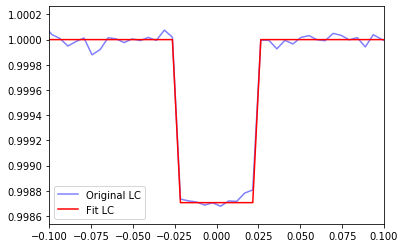

In [24]:
plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
plt.plot(time, fit_min, c='red', alpha=1.0, label='Fit LC')
plt.xlim(-0.1, 0.1)
plt.legend()

In [25]:
# Defining variables based on the fit parameters

p_f = popt[0]*86400 #days to seconds
perr_f = 0.001*86400 #days to seconds

rprs_f = popt[1]
rprserr_f = 0.001

a_f = popt[2]

i_f = popt[3] 

w_f = popt[4]

Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276


Input params:
Period (days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
w (deg):  90.0


Fit params:
Period (days):  4.838091976028503 Rp/Rs:  0.03596880385675803
a/Rs:  32.60280265008637
i (deg):  89.88719797179658
w (deg):  -78.03581955192794


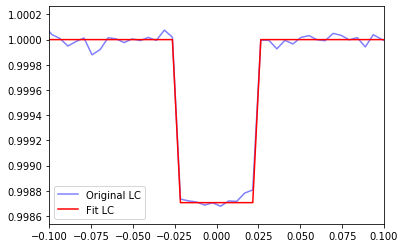

In [26]:
plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Period (days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)
print('w (deg): ', w)

print('\n')

print('Fit params:')
print('Period (days): ', p_f/86400., 'Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)
print('w (deg): ', w_f)

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [27]:
T14 = ph.get_T14(p_f, rprs_f, a_f, i_f)
T14err = 0.0001*86400 #I'm assuming a T14 error here

T23 = ph.get_T23(p_f, rprs_f, a_f, i_f)
T23err = 0.0001*86400 #I'm assuming a T23 error here

3486.208208774419

In [115]:
p_f/86400

4.844052456439763

In [116]:
p_f

418526.1322363955

In [112]:
rprs_f

0.03179741196397751

# Get $g$

Finally, we can use all the values above to determine $\rho_{circ}$. $\rho_{circ}$ is what we would calculate the stellar density to be if we knew that the orbit was definitely perfectly circular. We  will compare $\rho_{circ}$ to $\rho_{star}$ (the true, observed stellar density we calculated from spectroscopy/Gaia), and get $g(e, w)$:
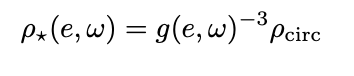

which is also defined as 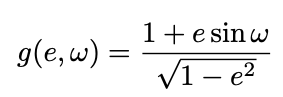

Thus, if the orbit is circular $(e = 0)$, then $g$ should equal 1. If the orbit is not circular $(e != 0)$, then $\rho_{circ}$ should differ from $\rho_{star}$, and $g$ should be something other than 1. We can draw a $(e, w)$ distribution based on the value we calcaulte for $g(e,w)$!

`ph.get_g_distribution()` will help us determine the value of g. This function takes the observed $\rho_{star}$ as well as the fit (circular) transit parameters and calculated transit durations, and calculates $\rho_{circ}$ and $g(e,w)$ based on equations 6 and 7 in [Dawson & Johnson 2012](https://arxiv.org/pdf/1203.5537.pdf).

In [108]:
gs, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f, perr_f, rprs_f, rprserr_f, T14, T14err, T23, T23err)

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 42674.91it/s]


Print $g$ and $\sigma_{g}$:

In [109]:
g_mean

1.081024441683672

In [41]:
g_sigma

0.06102614571240583

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use MCMC (`emcee`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [42]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [82]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

NameError: name 'nwalkers' is not defined

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples)
plt.xlabel('eccentricity')
plt.ylabel('w')

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!

# $e=0.3$, $w=90.0$

Let's do that again, but this time I'll do an eccentric orbit: e = 0.3 and w = 90.

In [153]:
time = np.linspace(-24, 24, 10000)

In [154]:
def planetlc(time, per, rp, a, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.3
    params.w = w                          #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [161]:
# Calculate flux from transit model
w = 90.0
flux = planetlc(time, period, rprs, a_rs, i, w)

# Adding some gaussian noise
noise = np.random.normal(0,0.00005,len(time))
nflux = flux+noise

Text(0, 0.5, 'Flux')

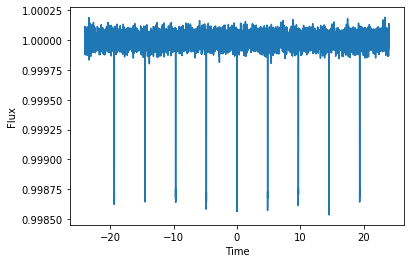

In [162]:
plt.plot(time, nflux)
plt.xlabel('Time')
plt.ylabel('Flux')
#plt.xlim(-1, 1)

## Fitting the transit

Using astropy BLS:

In [163]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")
per_guess = np.asarray(periodogram.period)[int(np.median(np.argmax(periodogram.power)))]

And fitting the transit using `ph.planetlc_fitter()`.

As explained above, because here the true eccentricity of the orbit is not zero, the transit fitter should fit the wrong values for $a/Rs$ and $i$ in a way that reveals the eccentricity of the orbit.

I enter an initial guess based on what I estimate the fit parameters will be: here, I'll try guesses for $a/Rs$ and $i$ that are slightly larger and smaller than the true values, respectively.

In [164]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [per_guess, rprs, 40, 89, w]

# Priors (bounds) on some parameters
priors = ((-np.inf, -np.inf, -np.inf, 0.0, -90.0), (np.inf, np.inf, np.inf, np.inf, 300.0))

popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0, bounds=priors)

# Create a light curve with the fit parameters
fit = ph.planetlc_fitter(time, popt[0], popt[1], popt[2], popt[3], popt[4])


In [165]:
# Defining variables based on the fit parameters

p_f = popt[0]*86400 #days to seconds
perr_f = 0.001*86400 #days to seconds

rprs_f = popt[1]
rprserr_f = 0.001

a_f = popt[2]

i_f = popt[3] 

w_f = popt[4]

Printing the original and fit parameters, and plotting the original and fit light curves:

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276


Input params:
Period (days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
w (deg):  90.0


Fit params:
Period (days):  4.837989683199733 Rp/Rs:  0.03618522121750792
a/Rs:  41.77339118534038
i (deg):  89.53061489047293
w (deg):  -76.24629821955637


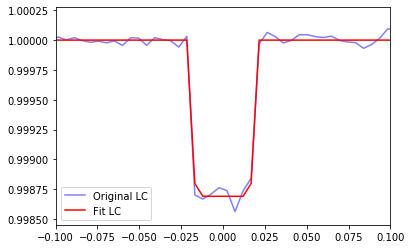

In [166]:
plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Period (days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)
print('w (deg): ', w)

print('\n')

print('Fit params:')
print('Period (days): ', p_f/86400., 'Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)
print('w (deg): ', w_f)

We need to calculate T14 and T23 again, and this time they should differ from the true transit durations because the equations we're using require $e = 0$, and we've input $e = 0.3$.

In [49]:
T14 = ph.get_T14(p_f, rprs_f, a_f, i_f)
T14err = 0.0001*86400 #I'm assuming a T14 error here

T23 = ph.get_T23(p_f, rprs_f, a_f, i_f)
T23err = 0.0001*86400 #I'm assuming a T23 error here

And now, we're getting $g$ in the same way as above, using `ph.get_g_distribution()`. 

In [50]:
gs, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f, perr_f, rprs_f, rprserr_f, T14, T14err, T23, T23err)

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 96700.88it/s]


Print $g$ and $\sigma_{g}$:

In [51]:
g_mean

1.2485383430087065

In [52]:
g_sigma

0.0765561717030141

The mean of $g$ is not 1 this time. It's about 1.3, which means that $\rho_{circ}$ differs from $\rho_{star}$ and the eccentricity of this transit must NOT be zero! This is good. Let's take $g$ and $\sigma_{g}$ and use MCMC again to see if the most likely $e$ is 0.3, as we input.

In [53]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [54]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:11<00:00, 427.53it/s]


Text(0.5, 0, 'eccentricity')

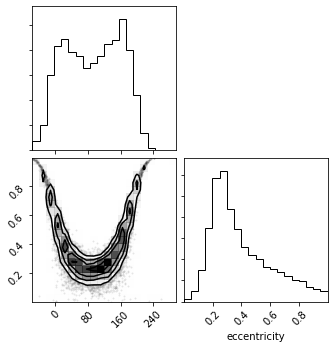

In [57]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples)
plt.xlabel('eccentricity')

Here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1.3$. This $e$ distribution peaks at about 0.3, which is exactly what we expect based on the transit we created!

# $e=0.3$, $w=-90.0$

Let's do one more, this time a planet with the same eccentricity $e = 0.3$, but where the longitude of periastron $\omega$ is -90 deg (insteadl of 90 deg). This means that this planet would be passing in front of the star (from our perspective) at the "long" side of its orbital ellipse, instead of the "short" side. A planet with $\omega = -90$ will produce the longest transit possible, while a planet with $\omega = +90$ will produce the shortest transit possible, assuming that all other parameters are the same. 

`photoeccentric` should catch onto this, and produce an $(e, w)$ surface that corresponds to the most likely $w$.

In [167]:
time = np.linspace(-24, 24, 10000)

In [168]:
def planetlc(time, per, rp, a, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.3
    params.w = w                          #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [169]:
# Calculate flux from transit model
w = -90.0
flux = planetlc(time, period, rprs, a_rs, i, w)

# Adding some gaussian noise
noise = np.random.normal(0,0.00005,len(time))
nflux = flux+noise

## Fitting the transit

Using astropy BLS:

In [170]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")
per_guess = np.asarray(periodogram.period)[int(np.median(np.argmax(periodogram.power)))]

And fitting the transit using `ph.planetlc_fitter()`.

The true eccentricity of this orbit is again not zero, so the transit fitter should fit the wrong values for $a/Rs$ and $i$ in a way that reveals the eccentricity of the orbit.

I enter an initial guess based on what I estimate the fit parameters will be: here, I'll try guesses for $a/Rs$ and $i$ that are slightly smaller than both of these true values.

In [171]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [per_guess, rprs, 20, 89, -80]

# Priors (bounds) on some parameters
priors = ((-np.inf, -np.inf, -np.inf, 0.0, -90.0), (np.inf, np.inf, np.inf, np.inf, 300.0))

popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0, bounds=priors)

# Create a light curve with the fit parameters
fit = ph.planetlc_fitter(time, popt[0], popt[1], popt[2], popt[3], popt[4])


In [172]:
# Defining variables based on the fit parameters

p_f = popt[0]*86400 #days to seconds
perr_f = 0.001*86400 #days to seconds

rprs_f = popt[1]
rprserr_f = 0.001

a_f = popt[2]

i_f = popt[3] 

w_f = popt[4]

Printing the original and fit parameters, and plotting the original and fit light curves:

Input params:
Period (days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
w (deg):  -90.0


Fit params:
Period (days):  4.838080966069167 Rp/Rs:  0.03613479760896321
a/Rs:  23.970000785017042
i (deg):  89.99877083157921
w (deg):  -64.85968442420041


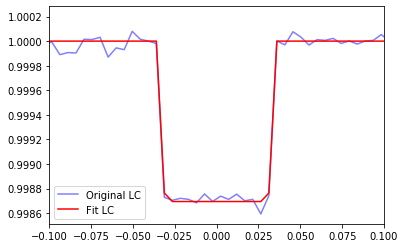

In [173]:
plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
plt.xlim(-0.1, 0.1)
plt.legend()

print('Input params:')
print('Period (days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)
print('w (deg): ', w)

print('\n')

print('Fit params:')
print('Period (days): ', p_f/86400., 'Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)
print('w (deg): ', w_f)

We need to calculate T14 and T23 again, and this time they should differ from the true transit durations because the equations we're using require $e = 0$, and we've input $e = 0.3$. 

How will `ph.get_T14()` and `ph.get_T23()` know that the planet is transiting at apoapse ($\omega = -90$) instead of periapse ($\omega = 90$)? Because the fit values for $a/Rs$ and $i$ compensate for the change in transit duration! All the information we need is encoded into the fit $a/Rs$ and $i$.

In [174]:
T14 = ph.get_T14(p_f, rprs_f, a_f, i_f)
T14err = 0.0001*86400 #I'm assuming a T14 error here

T23 = ph.get_T23(p_f, rprs_f, a_f, i_f)
T23err = 0.0001*86400 #I'm assuming a T23 error here

And now, we're getting $g$ in the same way as above, using `ph.get_g_distribution()`. 

In [175]:
gs, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f, perr_f, rprs_f, rprserr_f, T14, T14err, T23, T23err)

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 97819.49it/s]


Print $g$ and $\sigma_{g}$:

In [176]:
g_mean

0.7341747218539212

In [177]:
g_sigma

0.0428968081051907

The mean of $g$ this time is about 0.7. Again, this means that $\rho_{circ}$ differs from $\rho_{star}$ and the eccentricity must not be zero. 

But why is g less than 1, when in the previous example (with the same eccentricity) g was greater than 1?

Let's take $g$ and $\sigma_{g}$ and use MCMC again to see what the most likely $(e, w)$ surface looks like.

In [178]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [179]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:09<00:00, 553.04it/s]


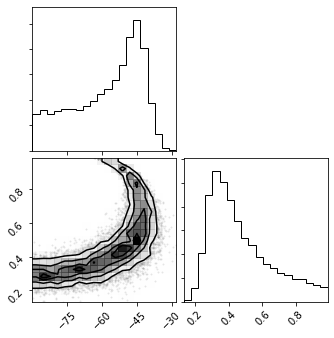

In [181]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples)

In this corner plot, $e$ peaks at about 0.3 again! The $\omega$ distribution differs though -- this time, where $e = 0.3$ on this distribution, $\omega$ can equal -90. (If you look back at the previous example, $e = 0.3$ and $\omega = -90$ was inconsistent with the probability distribution in the corner plot.) So `photoeccentric` was able to accurately determine $(e, w)$ for at least these three cases!